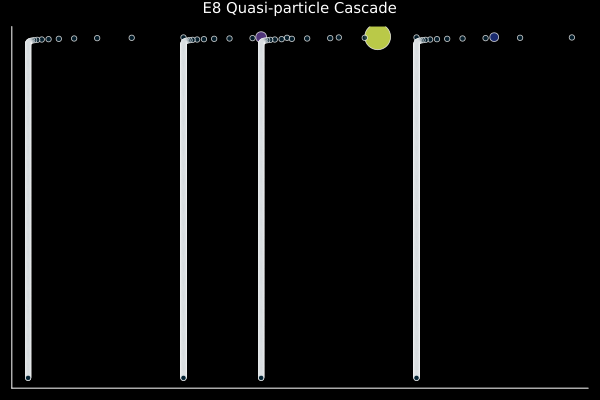

In [23]:
using LinearAlgebra, StatsBase, Plots, Printf

# --- 1. E8の物理量の定義 ---

"""
ZamolodchikovによるE8質量スペクトルの定義
m1を基準(=1.0)とした質量比を返す
Reference: A.B. Zamolodchikov, Int. J. Mod. Phys. A4 (1989) 4235.
"""
function get_e8_masses()
    # 黄金比
    ϕ = (1 + sqrt(5)) / 2
    # 質量比の解析解（一部近似を含むが数値計算用として定義）
    # m1 = 1
    # m2 = 2cos(π/5) = 1.618... (Golden Ratio)
    # m3 = 2cos(π/30) ≈ 1.989
    # m4 = 4cos(π/5)cos(7π/30) ≈ 2.405
    # m5 = 4cos(π/5)cos(2π/15) ≈ 2.956
    # m6 = 4cos(π/5)cos(π/30) ≈ 3.218
    # m7 = 8cos(π/5)cos(7π/30)cos(2π/15) ≈ 3.891
    # m8 = 8cos(π/5)^2 cos(2π/15) ≈ 4.783

    m1 = 1.0
    m2 = 2 * cos(pi / 5)
    m3 = 2 * cos(pi / 30)
    m4 = 2 * m2 * cos(7 * pi / 30)
    m5 = 2 * m2 * cos(2 * pi / 15)
    m6 = 2 * m2 * cos(pi / 30)
    m7 = 4 * m2 * cos(7 * pi / 30) * cos(2 * pi / 15)
    m8 = 8 * (cos(pi / 5)^2) * cos(2 * pi / 15)

    return [m1, m2, m3, m4, m5, m6, m7, m8]
end

# --- 2. L-Systemのルール構築 ---

struct Particle
    id::Int       # 1~8 (m1~m8)
    mass::Float64
    x::Float64    # 描画用座標
    y::Float64    # 描画用座標（深さ）
end

"""
崩壊チャネルの候補と確率を計算する
親粒子 parent_id に対して、m_i + m_j ≈ m_parent となるペアを探す
"""
function get_decay_options(parent_id, masses, temp)
    β = 1.0 / temp
    parent_mass = masses[parent_id]
    options = Vector{Tuple{Int,Int}}()
    weights = Float64[]

    # 安定粒子m1は崩壊しない（恒等写像）
    if parent_id == 1
        return [(1, 0)], [1.0] # 0は「消滅なし」のダミー
    end

    # 軽い粒子2つへの崩壊候補を探索
    for i in 1:parent_id # 自分より軽いか同等の粒子へ
        for j in 1:i
            # 質量保存（共鳴）の度合いをエネルギーコストとする
            # 仮想的な崩壊幅 Γ ~ exp(-β * |ΔE|)
            mass_deficit = abs(parent_mass - (masses[i] + masses[j]))

            # E8の物理として、あまりに質量差がある崩壊は抑制する
            # ここでは閾値を設けて候補を絞る
            if mass_deficit < 1.5
                push!(options, (i, j))
                push!(weights, exp(-β * mass_deficit))
            end
        end
    end

    # 候補がなければそのまま維持（確率100%）
    if isempty(options)
        return [(parent_id, 0)], [1.0]
    end

    return options, weights
end

# --- 3. 成長（崩壊）シミュレーション ---

function simulate_e8_cascade(steps, temp, start_particle_id=8)
    masses = get_e8_masses()

    # 初期状態: 最も重い粒子 m8 を一つ配置
    current_particles = [Particle(start_particle_id, masses[start_particle_id], 0.0, 0.0)]

    history = [current_particles] # 描画用に履歴を保存

    for s in 1:steps
        next_particles = Particle[]

        for p in current_particles
            # 粒子pに対する崩壊ルールを確率的に選択
            options, weights = get_decay_options(p.id, masses, temp)
            choice_idx = sample(1:length(options), Weights(weights))
            (child1_id, child2_id) = options[choice_idx]

            # 座標計算（ツリー状に広げる）
            # ノイズを加えて自然な分岐に見せる
            spread = 1.0 / (1.5^s)

            # 子1の生成
            p1 = Particle(child1_id, masses[child1_id], p.x - spread, p.y - 1.0)
            push!(next_particles, p1)

            # 子2の生成（0なら生成なし＝単独維持だった場合）
            if child2_id != 0
                p2 = Particle(child2_id, masses[child2_id], p.x + spread, p.y - 1.0)
                push!(next_particles, p2)
            end
        end

        current_particles = next_particles
        push!(history, current_particles)
    end

    return history, masses
end

# --- 4. 可視化 ---

function plot_e8_tree(history, masses)
    p = plot(legend=false, axis=nothing, grid=false, background_color=:black, title="E8 Quasi-particle Cascade", titlefont=font(10, :white))

    # 粒子IDごとの色定義（m1:青 -> m8:赤）
    colors = cgrad(:thermal, 8, categorical=true)

    # 枝の描画（履歴を遡って親と子を結ぶ線を描くのは大変なので、今回は点群として描画）
    # 本格的にはGraphRecipesを使うと良いが、ここでは簡易的に散布図で表現

    for (depth, particles) in enumerate(history)
        xs = [p.x for p in particles]
        ys = [p.y for p in particles]
        ids = [p.id for p in particles]
        ms = [p.mass for p in particles]

        # サイズを質量に比例させる
        sizes = ms .* 3.0

        # 色をIDに対応させる
        point_colors = [colors[id] for id in ids]

        scatter!(p, xs, ys, marker_z=ids, color=colors, markersize=sizes, alpha=0.8)
    end

    return p
end

# --- 実行 ---
# 温度T: これが「質量の不一致」をどれくらい許容するかのパラメータ
# Tが小さいと厳密に質量保存する崩壊しか選ばれない（E8では完全な保存は稀なので何も起きないかも）
# Tが高いと、多様な崩壊チャネルが開く
steps = 1000
temp = 0

history, masses = simulate_e8_cascade(steps, temp, 8) # m8からスタート
plot_e8_tree(history, masses)


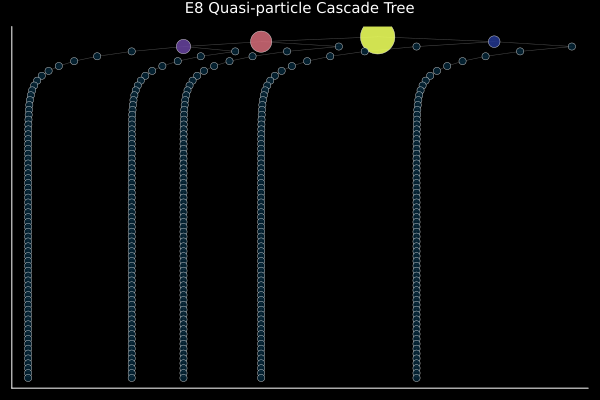

In [44]:
using LinearAlgebra, StatsBase, Plots, Printf

# --- 1. 構造体の変更 ---

# Particle構造体に「子」を記憶するフィールドを追加
mutable struct Particle
    id::Int
    mass::Float64
    x::Float64
    y::Float64
    children::Vector{Particle} # 新追加: 子粒子のリスト
end
# コンストラクタを定義（初期化時は子は空）
Particle(id, mass, x, y) = Particle(id, mass, x, y, Particle[])


# --- (get_e8_masses と get_decay_options は変更なし) ---
function get_e8_masses()
    m2 = 2 * cos(pi / 5)
    return [1.0, m2, 2 * cos(pi / 30), 2 * m2 * cos(7 * pi / 30), 2 * m2 * cos(2 * pi / 15), 2 * m2 * cos(pi / 30), 4 * m2 * cos(7 * pi / 30) * cos(2 * pi / 15), 8 * (cos(pi / 5)^2) * cos(2 * pi / 15)]
end

function get_decay_options(parent_id, masses, temp)
    β = 1.0 / temp
    parent_mass = masses[parent_id]
    options = Vector{Tuple{Int,Int}}()
    weights = Float64[]
    if parent_id == 1
        return [(1, 0)], [1.0]
    end
    for i in 1:parent_id, j in 1:i
        mass_deficit = abs(parent_mass - (masses[i] + masses[j]))
        if mass_deficit < 1.5
            push!(options, (i, j))
            push!(weights, exp(-β * mass_deficit))
        end
    end
    if isempty(options)
        return [(parent_id, 0)], [1.0]
    end
    return options, weights
end


# --- 2. シミュレーションの変更 ---

function simulate_e8_cascade_with_links(steps, temp, start_particle_id=8)
    masses = get_e8_masses()
    # 最初の親（ルート）を作成
    root = Particle(start_particle_id, masses[start_particle_id], 0.0, 0.0)
    current_particles = [root]

    # 描画用に全粒子をフラットなリストにも入れておく
    all_particles_flat = [root]

    for s in 1:steps
        next_particles = Particle[]
        for p in current_particles
            options, weights = get_decay_options(p.id, masses, temp)
            choice_idx = sample(1:length(options), Weights(weights))
            (child1_id, child2_id) = options[choice_idx]

            spread = 1.0 / (1.5^s) * 1.5 # 少し広がりを調整

            # 子1の生成とリンク
            p1 = Particle(child1_id, masses[child1_id], p.x - spread, p.y - 1.0)
            push!(p.children, p1) # 親に子を追加！
            push!(next_particles, p1)
            push!(all_particles_flat, p1)

            # 子2の生成とリンク
            if child2_id != 0
                p2 = Particle(child2_id, masses[child2_id], p.x + spread, p.y - 1.0)
                push!(p.children, p2) # 親に子を追加！
                push!(next_particles, p2)
                push!(all_particles_flat, p2)
            end
        end
        current_particles = next_particles
    end
    # ルートと、全粒子のリストを返す
    return root, all_particles_flat, masses
end


# --- 3. 描画関数の変更 ---

# 再帰的に線を引くためのヘルパー関数
function draw_lines_recursive!(plt, parent)
    for child in parent.children
        # 親から子へ線を引く
        plot!(plt, [parent.x, child.x], [parent.y, child.y],
            color=:white, alpha=0.3, lw=0.5, label="")
        # 子に対して同じ処理を繰り返す（再帰）
        draw_lines_recursive!(plt, child)
    end
end

function plot_e8_tree_final(root, all_particles, masses)
    p = plot(legend=false, axis=nothing, grid=false, background_color=:black,
        title="E8 Quasi-particle Cascade Tree", titlefont=font(10, :white))
    colors = cgrad(:thermal, 8, categorical=true)

    # 1. まず線を引く（再帰関数を呼び出す）
    draw_lines_recursive!(p, root)

    # 2. その上に点を描く
    xs = [pt.x for pt in all_particles]
    ys = [pt.y for pt in all_particles]
    ids = [pt.id for pt in all_particles]
    ms = [pt.mass for pt in all_particles]
    sizes = ms .* 4.0 # サイズを少し大きめに

    scatter!(p, xs, ys, marker_z=ids, color=colors, markersize=sizes, alpha=0.9, markerstrokecolor=:white, markerstrokewidth=0.5)

    return p
end

# --- 実行 ---
steps = 70        # ステップ数を少し減らすと見やすいかも
temp = 0.1       # 温度を少し下げると分岐が綺麗に見える
start_id = 8

root, all_particles, masses = simulate_e8_cascade_with_links(steps, temp, start_id)
plot_e8_tree_final(root, all_particles, masses)
